# Pulling Labelled Data For SCEPTR Evaluation & Finetuning

## Inclusion criteria
- Paired chain data
- At least 101 TCRs

## Exclusion criteria
- 10xGenomics whitepaper
- Non-human

All data will be cleaned with tidytcells and only standardizable and functional TCR data will be passed on.

In [1]:
import pandas as pd
from pandas import DataFrame
from pathlib import Path
import tidytcells as tt
from tqdm import tqdm

In [2]:
tcr_data_path = Path("../tcr_data/")

In [3]:
vdjdb = pd.read_csv(
    tcr_data_path/"raw"/"vdjdb"/"vdjdb_20240128.tsv",
    sep="\t"
)

In [4]:
vdjdb.head()

,complex.id,Gene,CDR3,V,J,Species,MHC A,MHC B,MHC class,Epitope,Epitope gene,Epitope species,Reference,Method,Meta,CDR3fix,Score
0,1,TRA,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CIVRAPGRADMRF"", ""cdr3_old"": ""CIVRAPG...",2
1,1,TRB,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSYLPGQGDHYSNQPQHF"", ""cdr3_old"": ""...",2
2,0,TRB,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSFEAGQGFFSNQPQHF"", ""cdr3_old"": ""C...",2
3,2,TRA,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAVPSGAGSYQLTF"", ""cdr3_old"": ""CAVPSG...",2
4,2,TRB,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSFEPGQGFYSNQPQHF"", ""cdr3_old"": ""C...",2


In [5]:
references = vdjdb["Reference"].dropna()
references_for_10x = references[references.str.contains("10x")]

In [6]:
references_for_10x.unique()

array(['https://www.10xgenomics.com/resources/application-notes/a-new-way-of-exploring-immunity-linking-highly-multiplexed-antigen-recognition-to-immune-repertoire-and-phenotype/#'],
      dtype=object)

In [7]:
def preprocess(df: DataFrame) -> DataFrame:
    df = enforce_exclusion_criteria(df)

    df = group_paired_chains(df)
    df = drop_rows_with_missing_data(df)
    df = standardize_nomenclature(df)
    
    df = enforce_inclusion_criteria(df)
    return df

def enforce_exclusion_criteria(df: DataFrame) -> DataFrame:
    df = remove_non_human_data(df)
    df = remove_10x_data(df)
    df = remove_single_chain_data(df)
    return df.copy()

def remove_non_human_data(df: DataFrame) -> DataFrame:
    return df[df["Species"] == "HomoSapiens"].copy()

def remove_10x_data(df: DataFrame) -> DataFrame:
    return df[df["Reference"] != "https://www.10xgenomics.com/resources/application-notes/a-new-way-of-exploring-immunity-linking-highly-multiplexed-antigen-recognition-to-immune-repertoire-and-phenotype/#"].copy()

def remove_single_chain_data(df: DataFrame) -> DataFrame:
    return df[df["complex.id"] != 0].copy()

def group_paired_chains(df: DataFrame) -> DataFrame:
    reformatted_rows = []

    sc_complex_ids = df["complex.id"].unique()
    for complex_id in tqdm(sc_complex_ids):
        tcr_info = df[df["complex.id"] == complex_id]

        if tcr_info.shape[0] != 2:
            print(tcr_info)
            raise RuntimeError

        tra_info = tcr_info[tcr_info["Gene"] == "TRA"].iloc[0]
        trb_info = tcr_info[tcr_info["Gene"] == "TRB"].iloc[0]

        reformatted_rows.append(
            {
                "TRAV": tra_info["V"],
                "CDR3A": tra_info["CDR3"],
                "TRAJ": tra_info["J"],
                "TRBV": trb_info["V"],
                "CDR3B": trb_info["CDR3"],
                "TRBJ": trb_info["J"],
                "Epitope": tra_info["Epitope"],
                "MHCA": tra_info["MHC A"],
                "MHCB": tra_info["MHC B"],
                "Epitope_species": tra_info["Epitope species"],
                "Reference": tra_info["Reference"]
            }
        )

    reformatted_df = DataFrame.from_records(reformatted_rows)
    reformatted_df = reformatted_df.drop_duplicates()
    return reformatted_df

def drop_rows_with_missing_data(df: DataFrame) -> DataFrame:
    return df.dropna(subset=["TRAV", "CDR3A", "TRAJ", "TRBV", "CDR3B", "TRBJ", "Epitope"])

def standardize_nomenclature(df: DataFrame) -> DataFrame:
    df["TRAV"] = df["TRAV"].map(lambda x: tt.tr.standardize(x, enforce_functional=True))
    df["TRAJ"] = df["TRAJ"].map(lambda x: tt.tr.standardize(x, enforce_functional=True))
    df["TRBV"] = df["TRBV"].map(lambda x: tt.tr.standardize(x, enforce_functional=True))
    df["TRBJ"] = df["TRBJ"].map(lambda x: tt.tr.standardize(x, enforce_functional=True))

    df["CDR3A"] = df["CDR3A"].map(tt.junction.standardize)
    df["CDR3B"] = df["CDR3B"].map(tt.junction.standardize)

    df["MHCA"] = df["MHCA"].map(tt.mh.standardize)
    df["MHCB"] = df["MHCB"].map(tt.mh.standardize)

    return df.copy()

def enforce_inclusion_criteria(df: DataFrame) -> DataFrame:
    df = remove_epitopes_with_less_than_k_tcrs(df, k=101)
    df = remove_epitopes_only_annotated_by_one_study(df)
    return df.copy()

def remove_epitopes_with_less_than_k_tcrs(df: DataFrame, k: int) -> DataFrame:
    grouped_by_epitope = df.groupby(by="Epitope")
    num_tcrs_per_epitope = grouped_by_epitope.size()
    epitopes_with_enough_tcrs = num_tcrs_per_epitope[num_tcrs_per_epitope >= k].index
    return df[
        df.apply(
            lambda row: row["Epitope"] in epitopes_with_enough_tcrs,
            axis=1
        )
    ].copy()

def remove_epitopes_only_annotated_by_one_study(df: DataFrame) -> DataFrame:
    grouped_by_epitopes = df.groupby("Epitope")
    num_references_per_epitope = grouped_by_epitopes.aggregate({"Reference": "nunique"})
    epitopes_with_multiple_references = num_references_per_epitope[num_references_per_epitope["Reference"] > 1].index
    return df[df["Epitope"].isin(epitopes_with_multiple_references)].copy()

In [8]:
vdjdb_cleaned = preprocess(vdjdb)

  0%|          | 0/7986 [00:00<?, ?it/s]

100%|██████████| 7986/7986 [00:05<00:00, 1519.01it/s]
/home/yutanagano/Projects/sceptr_publication_analyses/.venv/lib64/python3.11/site-packages/tidytcells/_utils/warnings.py:12: UserWarning: Failed to standardize "HLA-A*08:01" for species homosapiens: nonexistent allele for recognised gene.
  warn(warning_message)
/home/yutanagano/Projects/sceptr_publication_analyses/.venv/lib64/python3.11/site-packages/tidytcells/_utils/warnings.py:12: UserWarning: Failed to standardize "HLA-A*24:01" for species homosapiens: nonexistent allele for recognised gene.
  warn(warning_message)
/home/yutanagano/Projects/sceptr_publication_analyses/.venv/lib64/python3.11/site-packages/tidytcells/_utils/warnings.py:12: UserWarning: Failed to standardize "HLA-DPA*01:03" for species homosapiens: unrecognised gene name.
  warn(warning_message)
/home/yutanagano/Projects/sceptr_publication_analyses/.venv/lib64/python3.11/site-packages/tidytcells/_utils/warnings.py:12: UserWarning: Failed to standardize "HLA-B*12" 

<Axes: xlabel='Epitope'>

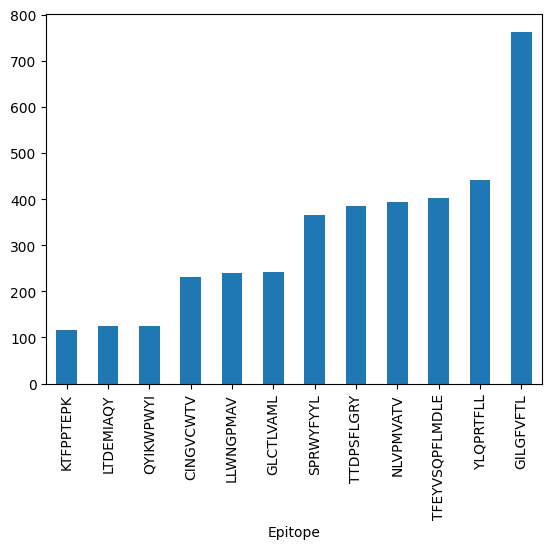

In [9]:
vdjdb_cleaned.groupby("Epitope").size().sort_values().plot(kind="bar")

In [10]:
vdjdb_cleaned.to_csv(tcr_data_path/"preprocessed"/"benchmarking"/"vdjdb_cleaned.csv", index=False)